# COURSE: A deep understanding of deep learning
## SECTION: ANNs
### LECTURE: Multi-output ANN (iris dataset)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [1]:
# import libraries
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# check out the first few lines of data
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


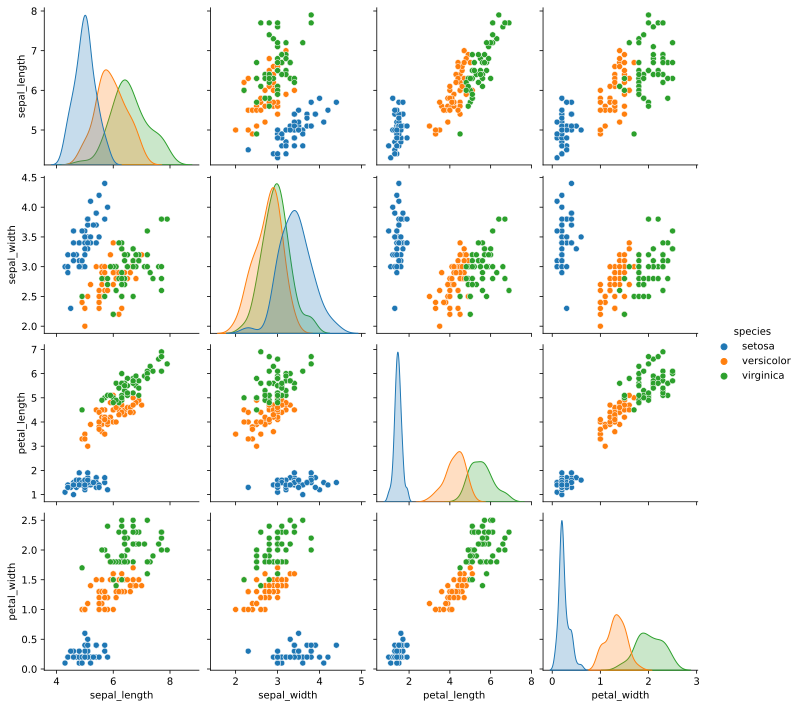

In [3]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()

In [6]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

# Create the ANN model

In [ ]:
# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),   # input layer
    nn.ReLU(),         # activation
    nn.Linear(64,64),  # hidden layer
    nn.ReLU(),         # activation
    nn.Linear(64,3),   # output layer
      )

# loss function
lossfun = nn.CrossEntropyLossropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

# Train the model

In [ ]:
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100 
  ongoingAcc.append( accuracyPct )              # add to list of accuracies



# final forward pass
predictions = ANNiris(data)
  
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

In [ ]:
torch.argmax(yHat,axis=1)

# Visualize the results

In [ ]:
# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

In [ ]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(yHat),axis=1)

In [ ]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

plt.plot(yHat.detach(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# try it again without the softmax!

# Additional explorations

In [ ]:
# 1) When the loss does not reach an asymptote, it's a good idea to train the model for more epochs. Increase the number of
#    epochs until the plot of the losses seems to hit a "floor" (that's a statistical term for being as small as possible).
# 
# 2) We used a model with 64 hidden units. Modify the code to have 16 hidden units. How does this model perform? If there
#    is a decrease in accuracy, is that decrease distributed across all three iris types, or does the model learn some
#    iris types and not others?
# 
# 3) Write code to compute three accuracy scores, one for each iris type. In real DL projects, category-specific accuracies
#    are often more informative than the aggregated accuracy.
# 